# Transfer learning в решении задачи классификации цветов
Датасет классификации цветов (http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) состоит из 102 видов цветов встречаемых в Великобритании. Для каждого класса есть от 40 до 258 примеров, чего мало для обучения с нуля:
<img src="http://bennycheung.github.io/images/deep-transfer-learning-on-small-dataset/flower_train_samples_700.jpg" style="width:50%">

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import pickle
import scipy.io
import tarfile
import csv
from sklearn.model_selection import train_test_split

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow.keras.callbacks as C
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import optimizers

In [3]:
import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

In [4]:
print(os.listdir("/data1/datasets/flowers"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', keras.__version__)

['imagelabels.mat', '102flowers.tgz']
Python       : 3.9.12 (main, Jun  1 2022, 11:38:51) 
Numpy        : 1.22.3
Tensorflow   : 2.9.1
Keras        : 2.9.0


In [5]:
# Проверяем что у нас работает GPU
tf.test.gpu_device_name()

'/device:GPU:0'

Работаем уже с Tensorflow 2.1 но для воспроизводимости сохраним версии всех пакетов

In [6]:
!pip freeze > requirements.txt

/bin/bash: /home/greg/anaconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)


# Setup

In [7]:
# В сетап выношу основные настройки, так удобней их перебирать в дальнейшем

EPOCHS               = 5
BATCH_SIZE           = 8 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-3
VAL_SPLIT            = 0.2

CLASS_NUM            = 102
IMG_SIZE             = 250
IMG_CHANNELS         = 3
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '/data1/datasets/flowers/'
PATH = DATA_PATH + "work/"

In [8]:
os.makedirs(PATH,exist_ok=False)

In [9]:
# Setting seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

# Data

In [10]:
# прочитаем все названия файлов прям из архива и таргеты к ним
def get_all_filenames(tar_fn):
    with tarfile.open(tar_fn) as f:
        return [m.name for m in f.getmembers() if m.isfile()]

df = pd.DataFrame()
df['Id'] = sorted(get_all_filenames(DATA_PATH+"102flowers.tgz"))
df['Category'] = scipy.io.loadmat(DATA_PATH+'imagelabels.mat')['labels'][0] - 1  # классы (0, 1, 2, ...)
df['Category'] = df['Category'].astype(str)

In [11]:
df.head(5)

,Id,Category
0,jpg/image_00001.jpg,76
1,jpg/image_00002.jpg,76
2,jpg/image_00003.jpg,76
3,jpg/image_00004.jpg,76
4,jpg/image_00005.jpg,76


In [12]:
df['Category'].value_counts()

50    258
76    251
45    196
72    194
88    184
     ... 
6      40
44     40
33     40
0      40
26     40
Name: Category, Length: 102, dtype: int64

In [13]:
df['Category'].nunique()

102

In [14]:
print('Распаковываем картинки')
# Will unzip the files so that you can see them..
opened_tar = tarfile.open(DATA_PATH+"102flowers.tgz")
opened_tar.extractall(PATH)
print(os.listdir(PATH+'jpg')[:5])

Распаковываем картинки
['image_01453.jpg', 'image_02490.jpg', 'image_05444.jpg', 'image_00272.jpg', 'image_01171.jpg']


Пример картинок (random sample)


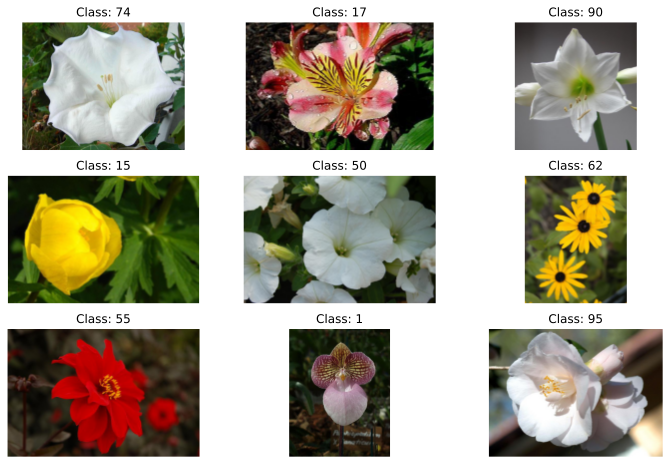

In [15]:
print('Пример картинок (random sample)')
plt.figure(figsize=(12,8))

random_image = df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+path)
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

Пример картинок (random sample)


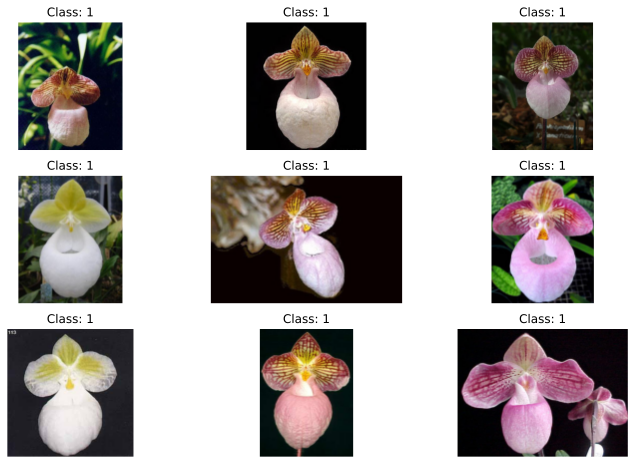

In [16]:
# убедимся что метки классов подгрузились верно
print('Пример картинок (random sample)')
plt.figure(figsize=(12,8))

random_image = df[df['Category']=='1'].sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+path)
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

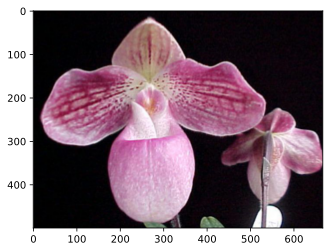

(667, 500)

In [17]:
# как видим изображения имеют разный размер
image = PIL.Image.open(PATH+path)
imgplot = plt.imshow(image)
plt.show()
image.size

 ## Stratify Split

In [19]:
# трейн / тест
train_files, test_files, train_labels, test_labels = \
    train_test_split(df['Id'], df['Category'], test_size=0.2, random_state=RANDOM_SEED, stratify=df['Category'])

train_files = pd.DataFrame(train_files)
test_files = pd.DataFrame(test_files)
train_files['Category'] = train_labels
test_files['Category'] = test_labels

train_files.shape, test_files.shape

((6551, 2), (1638, 2))

In [20]:
train_files.head(5)

,Id,Category
2361,jpg/image_02362.jpg,42
512,jpg/image_00513.jpg,87
5969,jpg/image_05970.jpg,68
6251,jpg/image_06252.jpg,60
516,jpg/image_00517.jpg,87


In [21]:
train_files['Category'].value_counts()

50    206
76    201
45    157
72    155
88    147
     ... 
0      32
6      32
33     32
2      32
26     32
Name: Category, Length: 102, dtype: int64

In [22]:
test_files['Category'].value_counts()

50    52
76    50
72    39
45    39
88    37
      ..
78     8
0      8
20     8
24     8
66     8
Name: Category, Length: 102, dtype: int64

### Data augmentation

In [23]:
# Аугментация данных очень важна когда у нас не большой датасет (как в нашем случае)

train_datagen = ImageDataGenerator(rescale=1. / 255, 
                                    rotation_range = 50,
                                    shear_range=0.2,
                                    zoom_range=[0.75,1.25],
                                    brightness_range=[0.5, 1.5],
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1. / 255)

### datagen

In [24]:
# "Заворачиваем" наши данные в generator

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_files,
    directory=PATH,
    x_col="Id",
    y_col="Category",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    seed=RANDOM_SEED,)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_files,
    directory=PATH,
    x_col="Id",
    y_col="Category",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False, 
    seed=RANDOM_SEED,)

Found 6551 validated image filenames belonging to 102 classes.
Found 1638 validated image filenames belonging to 102 classes.


In [25]:
from skimage import io

In [26]:
def imshow(image_RGB):
    io.imshow(image_RGB)
    io.show()

Пример картинок из train_generator


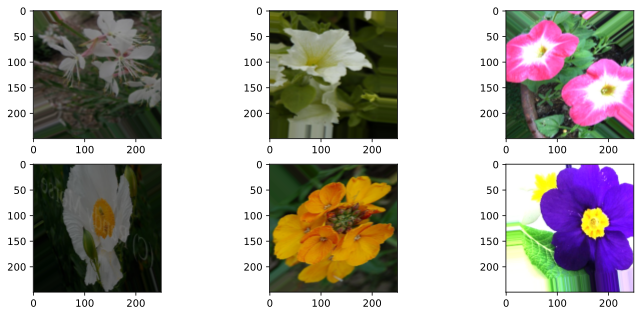

In [27]:
x,y = train_generator.next()
print('Пример картинок из train_generator')
plt.figure(figsize=(12,8))

for i in range(0,6):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
    #plt.title('Class: '+str(y[i]))
    #plt.axis('off')
plt.show()

Пример картинок из test_generator


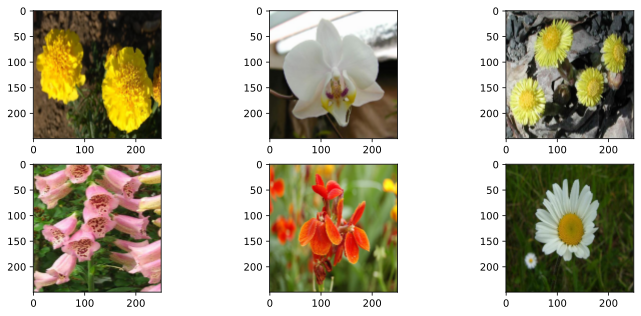

In [28]:
x,y = test_generator.next()
print('Пример картинок из test_generator')
plt.figure(figsize=(12,8))

for i in range(0,6):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
    #plt.title('Class: '+str(y[i]))
    #plt.axis('off')
plt.show()

# Model

In [29]:
input_shape

(250, 250, 3)

In [30]:
!nvidia-smi

/bin/bash: /home/greg/anaconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Wed Jul 27 18:29:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| 30%   42C    P3    83W / 350W |    837MiB / 12288MiB |     39%      Default |
|                               |                      |                  N/A |
+-------------------------------+-------------------

In [34]:
#base_model = efn.EfficientNetB7(weights='imagenet', include_top=False, input_shape=input_shape)

In [32]:
base_model = tf.keras.applications.EfficientNetB7(include_top=False, weights='imagenet', input_shape=input_shape)

258076736/258076736 [==============================] - 23s 0us/step


In [33]:
base_model.summary()

Model: "efficientnetb7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 250, 250, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 250, 250, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 250, 250, 3)  0           ['normalization[0][0

 block1c_dwconv (DepthwiseConv2  (None, 125, 125, 32  288        ['block1b_add[0][0]']            
 D)                             )                                                                 
                                                                                                  
 block1c_bn (BatchNormalization  (None, 125, 125, 32  128        ['block1c_dwconv[0][0]']         
 )                              )                                                                 
                                                                                                  
 block1c_activation (Activation  (None, 125, 125, 32  0          ['block1c_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block1c_se_squeeze (GlobalAver  (None, 32)          0           ['block1c_activation[0][0]']     
 agePoolin

                                                                                                  
 block2a_activation (Activation  (None, 63, 63, 192)  0          ['block2a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block2a_se_squeeze (GlobalAver  (None, 192)         0           ['block2a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block2a_se_reshape (Reshape)   (None, 1, 1, 192)    0           ['block2a_se_squeeze[0][0]']     
                                                                                                  
 block2a_se_reduce (Conv2D)     (None, 1, 1, 8)      1544        ['block2a_se_reshape[0][0]']     
          

                                                                                                  
 block2c_se_expand (Conv2D)     (None, 1, 1, 288)    3744        ['block2c_se_reduce[0][0]']      
                                                                                                  
 block2c_se_excite (Multiply)   (None, 63, 63, 288)  0           ['block2c_activation[0][0]',     
                                                                  'block2c_se_expand[0][0]']      
                                                                                                  
 block2c_project_conv (Conv2D)  (None, 63, 63, 48)   13824       ['block2c_se_excite[0][0]']      
                                                                                                  
 block2c_project_bn (BatchNorma  (None, 63, 63, 48)  192         ['block2c_project_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 block2e_project_conv (Conv2D)  (None, 63, 63, 48)   13824       ['block2e_se_excite[0][0]']      
                                                                                                  
 block2e_project_bn (BatchNorma  (None, 63, 63, 48)  192         ['block2e_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2e_drop (Dropout)         (None, 63, 63, 48)   0           ['block2e_project_bn[0][0]']     
                                                                                                  
 block2e_add (Add)              (None, 63, 63, 48)   0           ['block2e_drop[0][0]',           
                                                                  'block2d_add[0][0]']            
          

                                                                                                  
 block2g_drop (Dropout)         (None, 63, 63, 48)   0           ['block2g_project_bn[0][0]']     
                                                                                                  
 block2g_add (Add)              (None, 63, 63, 48)   0           ['block2g_drop[0][0]',           
                                                                  'block2f_add[0][0]']            
                                                                                                  
 block3a_expand_conv (Conv2D)   (None, 63, 63, 288)  13824       ['block2g_add[0][0]']            
                                                                                                  
 block3a_expand_bn (BatchNormal  (None, 63, 63, 288)  1152       ['block3a_expand_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 block3c_expand_bn (BatchNormal  (None, 32, 32, 480)  1920       ['block3c_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block3c_expand_activation (Act  (None, 32, 32, 480)  0          ['block3c_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3c_dwconv (DepthwiseConv2  (None, 32, 32, 480)  12000      ['block3c_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3c_b

 ivation)                                                                                         
                                                                                                  
 block3e_dwconv (DepthwiseConv2  (None, 32, 32, 480)  12000      ['block3e_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3e_bn (BatchNormalization  (None, 32, 32, 480)  1920       ['block3e_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block3e_activation (Activation  (None, 32, 32, 480)  0          ['block3e_bn[0][0]']             
 )                                                                                                
          

 block3g_bn (BatchNormalization  (None, 32, 32, 480)  1920       ['block3g_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block3g_activation (Activation  (None, 32, 32, 480)  0          ['block3g_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block3g_se_squeeze (GlobalAver  (None, 480)         0           ['block3g_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block3g_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block3g_se_squeeze[0][0]']     
          

 agePooling2D)                                                                                    
                                                                                                  
 block4b_se_reshape (Reshape)   (None, 1, 1, 960)    0           ['block4b_se_squeeze[0][0]']     
                                                                                                  
 block4b_se_reduce (Conv2D)     (None, 1, 1, 40)     38440       ['block4b_se_reshape[0][0]']     
                                                                                                  
 block4b_se_expand (Conv2D)     (None, 1, 1, 960)    39360       ['block4b_se_reduce[0][0]']      
                                                                                                  
 block4b_se_excite (Multiply)   (None, 16, 16, 960)  0           ['block4b_activation[0][0]',     
                                                                  'block4b_se_expand[0][0]']      
          

                                                                                                  
 block4d_se_expand (Conv2D)     (None, 1, 1, 960)    39360       ['block4d_se_reduce[0][0]']      
                                                                                                  
 block4d_se_excite (Multiply)   (None, 16, 16, 960)  0           ['block4d_activation[0][0]',     
                                                                  'block4d_se_expand[0][0]']      
                                                                                                  
 block4d_project_conv (Conv2D)  (None, 16, 16, 160)  153600      ['block4d_se_excite[0][0]']      
                                                                                                  
 block4d_project_bn (BatchNorma  (None, 16, 16, 160)  640        ['block4d_project_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 block4f_project_conv (Conv2D)  (None, 16, 16, 160)  153600      ['block4f_se_excite[0][0]']      
                                                                                                  
 block4f_project_bn (BatchNorma  (None, 16, 16, 160)  640        ['block4f_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4f_drop (Dropout)         (None, 16, 16, 160)  0           ['block4f_project_bn[0][0]']     
                                                                                                  
 block4f_add (Add)              (None, 16, 16, 160)  0           ['block4f_drop[0][0]',           
                                                                  'block4e_add[0][0]']            
          

                                                                                                  
 block4h_drop (Dropout)         (None, 16, 16, 160)  0           ['block4h_project_bn[0][0]']     
                                                                                                  
 block4h_add (Add)              (None, 16, 16, 160)  0           ['block4h_drop[0][0]',           
                                                                  'block4g_add[0][0]']            
                                                                                                  
 block4i_expand_conv (Conv2D)   (None, 16, 16, 960)  153600      ['block4h_add[0][0]']            
                                                                                                  
 block4i_expand_bn (BatchNormal  (None, 16, 16, 960)  3840       ['block4i_expand_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 block5a_expand_conv (Conv2D)   (None, 16, 16, 960)  153600      ['block4j_add[0][0]']            
                                                                                                  
 block5a_expand_bn (BatchNormal  (None, 16, 16, 960)  3840       ['block5a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5a_expand_activation (Act  (None, 16, 16, 960)  0          ['block5a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block5a_dwconv (DepthwiseConv2  (None, 16, 16, 960)  24000      ['block5a_expand_activation[0][0]
 D)       

                                                                                                  
 block5c_dwconv (DepthwiseConv2  (None, 16, 16, 1344  33600      ['block5c_expand_activation[0][0]
 D)                             )                                ']                               
                                                                                                  
 block5c_bn (BatchNormalization  (None, 16, 16, 1344  5376       ['block5c_dwconv[0][0]']         
 )                              )                                                                 
                                                                                                  
 block5c_activation (Activation  (None, 16, 16, 1344  0          ['block5c_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block5c_s

                                                                                                  
 block5e_bn (BatchNormalization  (None, 16, 16, 1344  5376       ['block5e_dwconv[0][0]']         
 )                              )                                                                 
                                                                                                  
 block5e_activation (Activation  (None, 16, 16, 1344  0          ['block5e_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block5e_se_squeeze (GlobalAver  (None, 1344)        0           ['block5e_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5e_s

                                                                                                  
 block5g_activation (Activation  (None, 16, 16, 1344  0          ['block5g_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block5g_se_squeeze (GlobalAver  (None, 1344)        0           ['block5g_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5g_se_reshape (Reshape)   (None, 1, 1, 1344)   0           ['block5g_se_squeeze[0][0]']     
                                                                                                  
 block5g_se_reduce (Conv2D)     (None, 1, 1, 56)     75320       ['block5g_se_reshape[0][0]']     
          

                                                                                                  
 block5i_se_squeeze (GlobalAver  (None, 1344)        0           ['block5i_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5i_se_reshape (Reshape)   (None, 1, 1, 1344)   0           ['block5i_se_squeeze[0][0]']     
                                                                                                  
 block5i_se_reduce (Conv2D)     (None, 1, 1, 56)     75320       ['block5i_se_reshape[0][0]']     
                                                                                                  
 block5i_se_expand (Conv2D)     (None, 1, 1, 1344)   76608       ['block5i_se_reduce[0][0]']      
                                                                                                  
 block5i_s

                                                                                                  
 block6a_se_squeeze (GlobalAver  (None, 1344)        0           ['block6a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6a_se_reshape (Reshape)   (None, 1, 1, 1344)   0           ['block6a_se_squeeze[0][0]']     
                                                                                                  
 block6a_se_reduce (Conv2D)     (None, 1, 1, 56)     75320       ['block6a_se_reshape[0][0]']     
                                                                                                  
 block6a_se_expand (Conv2D)     (None, 1, 1, 1344)   76608       ['block6a_se_reduce[0][0]']      
                                                                                                  
 block6a_s

 block6c_se_excite (Multiply)   (None, 8, 8, 2304)   0           ['block6c_activation[0][0]',     
                                                                  'block6c_se_expand[0][0]']      
                                                                                                  
 block6c_project_conv (Conv2D)  (None, 8, 8, 384)    884736      ['block6c_se_excite[0][0]']      
                                                                                                  
 block6c_project_bn (BatchNorma  (None, 8, 8, 384)   1536        ['block6c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6c_drop (Dropout)         (None, 8, 8, 384)    0           ['block6c_project_bn[0][0]']     
                                                                                                  
 block6c_a

 block6e_project_bn (BatchNorma  (None, 8, 8, 384)   1536        ['block6e_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6e_drop (Dropout)         (None, 8, 8, 384)    0           ['block6e_project_bn[0][0]']     
                                                                                                  
 block6e_add (Add)              (None, 8, 8, 384)    0           ['block6e_drop[0][0]',           
                                                                  'block6d_add[0][0]']            
                                                                                                  
 block6f_expand_conv (Conv2D)   (None, 8, 8, 2304)   884736      ['block6e_add[0][0]']            
                                                                                                  
 block6f_e

 block6g_add (Add)              (None, 8, 8, 384)    0           ['block6g_drop[0][0]',           
                                                                  'block6f_add[0][0]']            
                                                                                                  
 block6h_expand_conv (Conv2D)   (None, 8, 8, 2304)   884736      ['block6g_add[0][0]']            
                                                                                                  
 block6h_expand_bn (BatchNormal  (None, 8, 8, 2304)  9216        ['block6h_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6h_expand_activation (Act  (None, 8, 8, 2304)  0           ['block6h_expand_bn[0][0]']      
 ivation)                                                                                         
          

 block6j_expand_bn (BatchNormal  (None, 8, 8, 2304)  9216        ['block6j_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6j_expand_activation (Act  (None, 8, 8, 2304)  0           ['block6j_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6j_dwconv (DepthwiseConv2  (None, 8, 8, 2304)  57600       ['block6j_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block6j_bn (BatchNormalization  (None, 8, 8, 2304)  9216        ['block6j_dwconv[0][0]']         
 )        

                                                                                                  
 block6l_dwconv (DepthwiseConv2  (None, 8, 8, 2304)  57600       ['block6l_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block6l_bn (BatchNormalization  (None, 8, 8, 2304)  9216        ['block6l_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block6l_activation (Activation  (None, 8, 8, 2304)  0           ['block6l_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6l_s

 )                                                                                                
                                                                                                  
 block7a_activation (Activation  (None, 8, 8, 2304)  0           ['block7a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block7a_se_squeeze (GlobalAver  (None, 2304)        0           ['block7a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block7a_se_reshape (Reshape)   (None, 1, 1, 2304)   0           ['block7a_se_squeeze[0][0]']     
                                                                                                  
 block7a_s

 block7c_se_reduce (Conv2D)     (None, 1, 1, 160)    614560      ['block7c_se_reshape[0][0]']     
                                                                                                  
 block7c_se_expand (Conv2D)     (None, 1, 1, 3840)   618240      ['block7c_se_reduce[0][0]']      
                                                                                                  
 block7c_se_excite (Multiply)   (None, 8, 8, 3840)   0           ['block7c_activation[0][0]',     
                                                                  'block7c_se_expand[0][0]']      
                                                                                                  
 block7c_project_conv (Conv2D)  (None, 8, 8, 640)    2457600     ['block7c_se_excite[0][0]']      
                                                                                                  
 block7c_project_bn (BatchNorma  (None, 8, 8, 640)   2560        ['block7c_project_conv[0][0]']   
 lization)

In [35]:
# first: train only the top layers (which were randomly initialized)
base_model.trainable = False

In [36]:
model=M.Sequential()
model.add(base_model)
model.add(L.GlobalAveragePooling2D(),)
model.add(L.Dense(CLASS_NUM, activation='softmax'))

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional)  (None, 8, 8, 2560)       64097687  
                                                                 
 global_average_pooling2d (G  (None, 2560)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 102)               261222    
                                                                 
Total params: 64,358,909
Trainable params: 261,222
Non-trainable params: 64,097,687
_________________________________________________________________


In [38]:
# сколько слоев
print(len(model.layers))

3


In [39]:
len(model.trainable_variables)

2

In [40]:
# Check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

<keras.engine.functional.Functional object at 0x7fe9bc044a30> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7fe9a4657a30> True
<keras.layers.core.dense.Dense object at 0x7fe9bc0676a0> True


## Fit

In [41]:
MODEL_PATH = DATA_PATH + "model/"
os.makedirs(MODEL_PATH, exist_ok=False)

In [42]:
checkpoint = ModelCheckpoint(MODEL_PATH + 'best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
earlystop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]

In [43]:
LR=0.001
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=LR), metrics=["accuracy"])

In [44]:
scores = model.evaluate(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

2022-07-27 18:44:58.167546: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-07-27 18:44:58.168019: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


205/205 [==============================] - 18s 52ms/step - loss: 4.6462 - accuracy: 0.0061
Accuracy: 0.61%


In [45]:
# Обучаем
history = model.fit(
                    train_generator,
                    steps_per_epoch = train_generator.samples//train_generator.batch_size,
                    validation_data = test_generator, 
                    validation_steps = test_generator.samples//test_generator.batch_size,
                    epochs = 5,
                    callbacks = callbacks_list
                    )

Epoch 1/5
818/818 [==============================] - ETA: 0s - loss: 4.7575 - accuracy: 0.0182
Epoch 1: saving model to /data1/datasets/flowers/model/best_model.hdf5
818/818 [==============================] - 82s 89ms/step - loss: 4.7575 - accuracy: 0.0182 - val_loss: 4.7195 - val_accuracy: 0.0049
Epoch 2/5
818/818 [==============================] - ETA: 0s - loss: 4.7437 - accuracy: 0.0202
Epoch 2: saving model to /data1/datasets/flowers/model/best_model.hdf5
818/818 [==============================] - 73s 89ms/step - loss: 4.7437 - accuracy: 0.0202 - val_loss: 4.6823 - val_accuracy: 0.0319
Epoch 3/5
818/818 [==============================] - ETA: 0s - loss: 4.7300 - accuracy: 0.0223
Epoch 3: saving model to /data1/datasets/flowers/model/best_model.hdf5
818/818 [==============================] - 73s 89ms/step - loss: 4.7300 - accuracy: 0.0223 - val_loss: 4.6398 - val_accuracy: 0.0104
Epoch 4/5
818/818 [==============================] - ETA: 0s - loss: 4.7193 - accuracy: 0.0258
Epoch 4:

удивительно на сколько эта модель хорошо умеет извлекать признаки!
даже без дообучения получаем столь высокий Accuracy

In [46]:
model.save(MODEL_PATH + 'model_step1.hdf5')
model.load_weights(MODEL_PATH + 'best_model.hdf5')

In [47]:
scores = model.evaluate(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

205/205 [==============================] - 10s 49ms/step - loss: 4.6210 - accuracy: 0.0244
Accuracy: 2.44%


In [48]:
def plot_history(history):
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'g', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.show()

    #plt.figure()
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

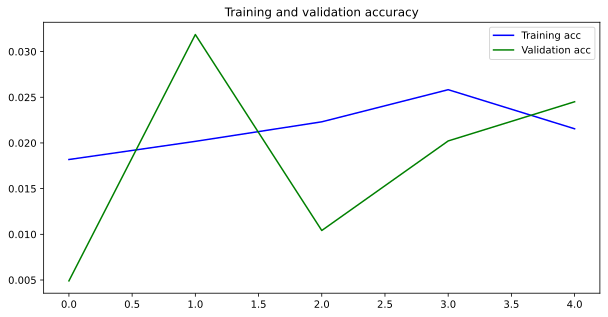

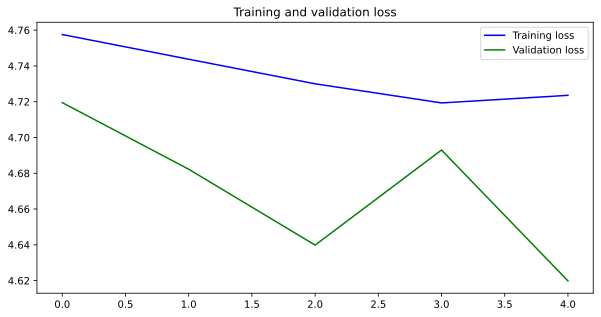

In [49]:
plot_history(history)

## Step 2

In [50]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  814


In [51]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = len(base_model.layers)//2

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [52]:
len(base_model.trainable_variables)

357

In [53]:
# Check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

<keras.engine.functional.Functional object at 0x7fe9bc044a30> True
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7fe9a4657a30> True
<keras.layers.core.dense.Dense object at 0x7fe9bc0676a0> True


In [54]:
LR=0.0001
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=LR), metrics=["accuracy"])

/home/greg/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [55]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional)  (None, 8, 8, 2560)       64097687  
                                                                 
 global_average_pooling2d (G  (None, 2560)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 102)               261222    
                                                                 
Total params: 64,358,909
Trainable params: 59,498,174
Non-trainable params: 4,860,735
_________________________________________________________________


In [56]:
scores = model.evaluate(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

/tmp/ipykernel_7759/1370569445.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(test_generator, verbose=1)


205/205 [==============================] - 14s 50ms/step - loss: 4.6210 - accuracy: 0.0244
Accuracy: 2.44%


In [57]:
# Обучаем
history = model.fit(
        train_generator,
        steps_per_epoch = train_generator.samples//train_generator.batch_size,
        validation_data = test_generator, 
        validation_steps = test_generator.samples//test_generator.batch_size,
        epochs = 10,
        callbacks = callbacks_list
)

Epoch 1/10
818/818 [==============================] - ETA: 0s - loss: 4.0814 - accuracy: 0.0934
Epoch 1: saving model to /data1/datasets/flowers/model/best_model.hdf5
818/818 [==============================] - 115s 124ms/step - loss: 4.0814 - accuracy: 0.0934 - val_loss: 3.0485 - val_accuracy: 0.2512
Epoch 2/10
818/818 [==============================] - ETA: 0s - loss: 2.9023 - accuracy: 0.2899
Epoch 2: saving model to /data1/datasets/flowers/model/best_model.hdf5
818/818 [==============================] - 101s 123ms/step - loss: 2.9023 - accuracy: 0.2899 - val_loss: 1.8873 - val_accuracy: 0.4982
Epoch 3/10
818/818 [==============================] - ETA: 0s - loss: 2.1429 - accuracy: 0.4438
Epoch 3: saving model to /data1/datasets/flowers/model/best_model.hdf5
818/818 [==============================] - 100s 122ms/step - loss: 2.1429 - accuracy: 0.4438 - val_loss: 1.3471 - val_accuracy: 0.6403
Epoch 4/10
818/818 [==============================] - ETA: 0s - loss: 1.6879 - accuracy: 0.552

In [58]:
model.save(MODEL_PATH + 'model_step2.hdf5')
model.load_weights(MODEL_PATH + 'best_model.hdf5')

In [59]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

  2/205 [..............................] - ETA: 10s - loss: 1.1553 - accuracy: 0.6875

/tmp/ipykernel_7759/1370569445.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(test_generator, verbose=1)


205/205 [==============================] - 10s 49ms/step - loss: 0.6893 - accuracy: 0.8260
Accuracy: 82.60%


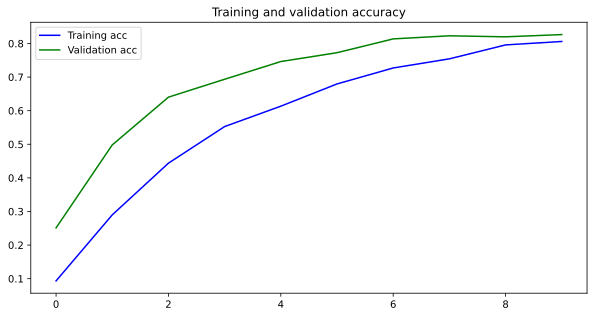

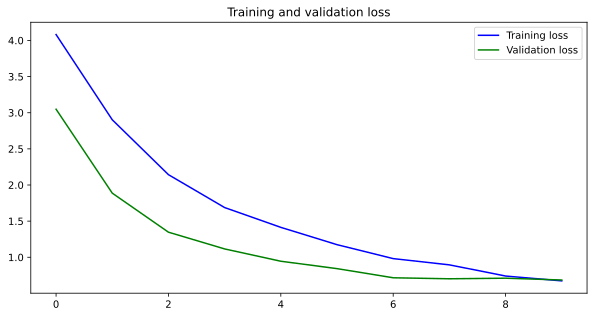

In [60]:
plot_history(history)

## Step 3

In [61]:
base_model.trainable = True

In [62]:
LR=0.00001
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=LR), metrics=["accuracy"])

In [63]:
# Обучаем
history = model.fit(
        train_generator,
        steps_per_epoch = train_generator.samples//train_generator.batch_size,
        validation_data = test_generator, 
        validation_steps = test_generator.samples//test_generator.batch_size,
        epochs = 10,
        callbacks = callbacks_list
)

Epoch 1/10
818/818 [==============================] - ETA: 0s - loss: 1.1667 - accuracy: 0.6844
Epoch 1: saving model to /data1/datasets/flowers/model/best_model.hdf5
818/818 [==============================] - 275s 317ms/step - loss: 1.1667 - accuracy: 0.6844 - val_loss: 0.5767 - val_accuracy: 0.8431
Epoch 2/10
818/818 [==============================] - ETA: 0s - loss: 0.5405 - accuracy: 0.8510
Epoch 2: saving model to /data1/datasets/flowers/model/best_model.hdf5
818/818 [==============================] - 257s 315ms/step - loss: 0.5405 - accuracy: 0.8510 - val_loss: 0.4103 - val_accuracy: 0.8897
Epoch 3/10
818/818 [==============================] - ETA: 0s - loss: 0.3965 - accuracy: 0.8906
Epoch 3: saving model to /data1/datasets/flowers/model/best_model.hdf5
818/818 [==============================] - 255s 312ms/step - loss: 0.3965 - accuracy: 0.8906 - val_loss: 0.3517 - val_accuracy: 0.8989
Epoch 4/10
818/818 [==============================] - ETA: 0s - loss: 0.3034 - accuracy: 0.918

In [64]:
model.save(MODEL_PATH + 'model_step3.hdf5')
model.load_weights(MODEL_PATH + 'best_model.hdf5')

In [65]:
scores = model.evaluate(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

205/205 [==============================] - 11s 51ms/step - loss: 0.1887 - accuracy: 0.9493
Accuracy: 94.93%


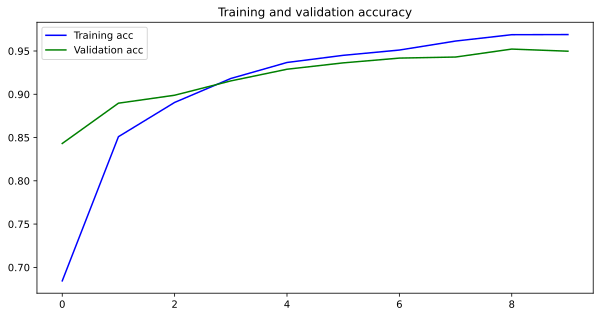

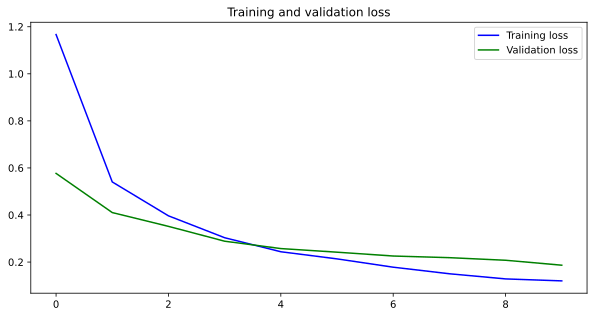

In [66]:
plot_history(history)

# Step 4

In [67]:
EPOCHS               = 5
BATCH_SIZE           = 4 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-5

IMG_SIZE             = 320
IMG_CHANNELS         = 3
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

In [68]:
train_datagen = ImageDataGenerator(rescale=1. / 255, 
                                    #rotation_range = 50,
                                    #shear_range=0.2,
                                    zoom_range=[0.75,1.25],
                                    #brightness_range=[0.5, 1.5],
                                    #width_shift_range=0.1,
                                    #height_shift_range=0.1,
                                    horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [69]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_files,
    directory=PATH,
    x_col="Id",
    y_col="Category",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    seed=RANDOM_SEED,)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_files,
    directory=PATH,
    x_col="Id",
    y_col="Category",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False, 
    seed=RANDOM_SEED,)

Found 6551 validated image filenames belonging to 102 classes.
Found 1638 validated image filenames belonging to 102 classes.


In [70]:
base_model = tf.keras.applications.EfficientNetB7(include_top=False, weights='imagenet', input_shape=input_shape)

In [71]:
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=LR), metrics=["accuracy"])

In [73]:
model.load_weights(MODEL_PATH + 'best_model.hdf5')

In [74]:
# Обучаем
history = model.fit(
        train_generator,
        steps_per_epoch = train_generator.samples//train_generator.batch_size,
        validation_data = test_generator, 
        validation_steps = test_generator.samples//test_generator.batch_size,
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/5


2022-07-27 20:23:48.033340: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.10GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-07-27 20:23:48.033371: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.10GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-07-27 20:23:48.405374: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.20GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-07-27 20:23:48.405402: W tensorflow/core/common_runtime/bfc_allocato

1637/1637 [==============================] - ETA: 0s - loss: 0.2790 - accuracy: 0.9441
Epoch 1: saving model to /data1/datasets/flowers/model/best_model.hdf5
1637/1637 [==============================] - 481s 284ms/step - loss: 0.2790 - accuracy: 0.9441 - val_loss: 0.1784 - val_accuracy: 0.9511
Epoch 2/5
1637/1637 [==============================] - ETA: 0s - loss: 0.1919 - accuracy: 0.9627
Epoch 2: saving model to /data1/datasets/flowers/model/best_model.hdf5
1637/1637 [==============================] - 474s 290ms/step - loss: 0.1919 - accuracy: 0.9627 - val_loss: 0.1752 - val_accuracy: 0.9517
Epoch 3/5
1637/1637 [==============================] - ETA: 0s - loss: 0.1407 - accuracy: 0.9745
Epoch 3: saving model to /data1/datasets/flowers/model/best_model.hdf5
1637/1637 [==============================] - 465s 284ms/step - loss: 0.1407 - accuracy: 0.9745 - val_loss: 0.1591 - val_accuracy: 0.9609
Epoch 4/5
1637/1637 [==============================] - ETA: 0s - loss: 0.1169 - accuracy: 0.979

In [75]:
model.save(MODEL_PATH + 'model_step4.hdf5')
model.load_weights(MODEL_PATH + 'best_model.hdf5')

In [76]:
scores = model.evaluate(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

410/410 [==============================] - 21s 50ms/step - loss: 0.1486 - accuracy: 0.9676
Accuracy: 96.76%


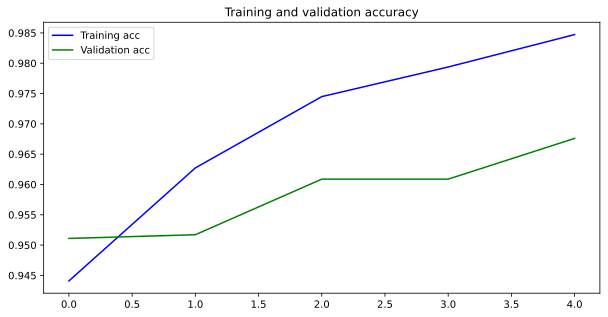

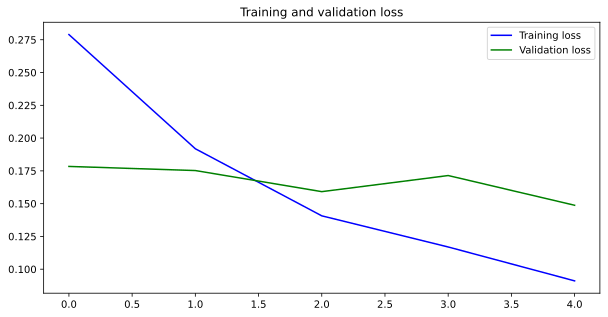

In [77]:
plot_history(history)

# Final Score

In [78]:
from sklearn.metrics import accuracy_score

In [79]:
predictions = model.predict(test_generator, verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

/tmp/ipykernel_7759/1450337842.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_generator, verbose=1)


410/410 [==============================] - 21s 45ms/step


In [80]:
filenames_with_dir=test_generator.filenames
submission = pd.DataFrame({'Predict':predictions}, columns=['Predict'], index=filenames_with_dir)
test_files.index = test_files['Id']
tmp_y = pd.concat([submission['Predict'], test_files['Category']], axis=1, sort=False)
tmp_y.head(5)

,Predict,Category
jpg/image_05001.jpg,46,46
jpg/image_07204.jpg,6,6
jpg/image_04014.jpg,11,11
jpg/image_07420.jpg,93,93
jpg/image_01122.jpg,45,45


In [81]:
print('Accuracy: %.2f%%' % (accuracy_score(tmp_y['Category'], tmp_y['Predict'],)*100))

Accuracy: 96.76%


# TTA

In [82]:
model.load_weights(MODEL_PATH + 'best_model.hdf5')

In [83]:
test_datagen = ImageDataGenerator(rescale=1. / 255,
                                 rotation_range = 90,
                                    shear_range=0.2,
                                    zoom_range=[0.75,1.25],
                                    brightness_range=[0.5, 1.5],
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,)

In [84]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_files,
    directory=PATH,
    x_col="Id",
    y_col="Category",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False, 
    seed=RANDOM_SEED,)

Found 1638 validated image filenames belonging to 102 classes.


Пример картинок из test_generator


IndexError: index 4 is out of bounds for axis 0 with size 4

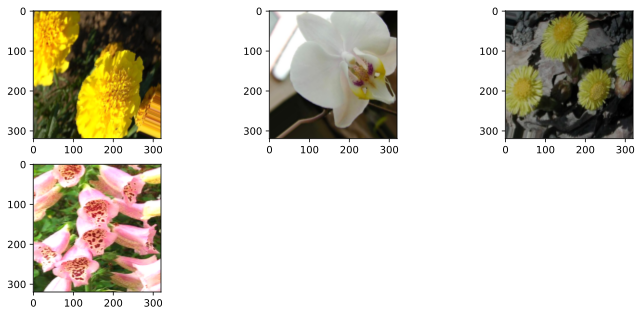

In [85]:
x,y = test_generator.next()
print('Пример картинок из test_generator')
plt.figure(figsize=(12,8))

for i in range(0,6):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
plt.show()

In [86]:
tta_steps = 10
predictions = []

for i in range(tta_steps):
    preds = model.predict(test_generator, verbose=1) 
    predictions.append(preds)

pred = np.mean(predictions, axis=0)

  1/410 [..............................] - ETA: 37s

/tmp/ipykernel_7759/1087677315.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_generator, verbose=1)


410/410 [==============================] - 23s 55ms/step


In [87]:
predictions = np.argmax(pred, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]
filenames_with_dir=test_generator.filenames
submission = pd.DataFrame({'Predict':predictions}, columns=['Predict'], index=filenames_with_dir)
tmp_y = pd.concat([submission['Predict'], test_files['Category']], axis=1, sort=False)

In [88]:
print('Accuracy: %.2f%%' % (accuracy_score(tmp_y['Category'], tmp_y['Predict'],)*100))

Accuracy: 96.15%


## clean

In [89]:
# Clean PATH
import shutil
shutil.rmtree(PATH)
shutil.rmtree(MODEL_PATH)